# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишем SQL-запрос, выгружающий в датафрейм pandas необходимые данные.


Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sqlalchemy import create_engine 
from dotenv import load_dotenv
from os import getenv
import ast
load_dotenv(dotenv_path="secret.env")
db_config_str = getenv("DB_CONFIG")
db_config = ast.literal_eval(db_config_str)
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)
with engine.connect() as connection:
    query = """WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT user_id,device_type_canonical,order_id,created_dt_msk AS order_dt,created_ts_msk AS order_ts,currency_code,revenue,tickets_count, CASE WHEN LAG(created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk) IS NULL THEN NULL ELSE  EXTRACT(DAY FROM (created_dt_msk - LAG(created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk))) END AS days_since_prev, event_id, event_name_code AS event_name, event_type_main, service_name, region_name, city_name
FROM afisha.purchases
LEFT JOIN afisha.events USING(event_id)
LEFT JOIN afisha.city USING(city_id)
LEFT JOIN afisha.regions USING(region_id)
WHERE (device_type_canonical IN ('mobile', 'desktop')) AND (event_type_main != 'фильм')
ORDER BY user_id"""
    df = pd.read_sql(query, connection)

---

**Задача 1.2:** Изучим общую информацию о выгруженных данных. Оценим корректность выгрузки и объём полученных данных.

---

In [2]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [4]:
df.shape

(290611, 15)

### Промежуточный вывод
Датасет содержит 15 столбцов и 290611 строк, в которых представлена информация о бронировании билетов Яндекс.Афиша. После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов корректны (snake case)
- Данные содержат текстовые данные (object), числовые значения (хранятся в типах данных int64 или float64), даты (datetime64). Все типы данных корректны (days_since_prev - это целые числа + NaN, но замена NaN на заглушку будет мешать дальнейшему анализу важного столбца). Есть возможность оптимизировать разрядность хранения.
- Пропуски есть в days_since_prev у клиентов, которые совершили только 1 заказ.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [5]:
#сделаем копию датафрейма для анализа
df_copy = df.copy()

In [6]:
exchange_rates = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
exchange_rates.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [7]:
exchange_rates['data'] = pd.to_datetime(exchange_rates['data'])
display(min(exchange_rates['data']), max(exchange_rates['data']))
display(min(df['order_dt']), max(df['order_dt']))

Timestamp('2024-01-10 00:00:00')

Timestamp('2024-12-31 00:00:00')

Timestamp('2024-06-01 00:00:00')

Timestamp('2024-10-31 00:00:00')

In [8]:
def convert_currency(row):
    if row['currency_code'] == 'kzt':
        rate = exchange_rates.loc[exchange_rates['data'] == row['order_dt']]['curs'].values[0]
        return row['revenue'] * rate / 100
    else:
        return row['revenue']
    
df['revenue_rub'] = df.apply(convert_currency, axis=1)
df[df['currency_code'] == 'kzt'].head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
70,0033403583a55ed,mobile,7850214,2024-09-17,2024-09-17 16:52:06,kzt,518.10,4,20.0,559919,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,другое,Билеты без проблем,Верхоречная область,Серебрянка,98.503762
89,0040e12d70fae81,desktop,8634925,2024-09-02,2024-09-02 19:49:14,kzt,347.18,3,39.0,559476,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,другое,Билеты без проблем,Верхоречная область,Серебрянка,65.731589
96,0054b38b2653e6e,mobile,7625522,2024-09-09,2024-09-09 18:06:04,kzt,328.77,4,NaN,559582,524f434e-0381-4f47-9688-7c4e41961b65,другое,Билеты без проблем,Верхоречная область,Серебрянка,61.148261
277,00f4f5244501ce6,mobile,720419,2024-06-11,2024-06-11 20:15:57,kzt,22021.55,5,NaN,536826,76af4f88-c554-4e9e-9df4-1cc8aeec8959,концерты,Мой билет,Верхоречная область,Серебрянка,4380.702898
460,01370a0e9c1a7d5,mobile,2229811,2024-06-04,2024-06-04 13:19:47,kzt,7397.66,4,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,1478.296591


Пересчитали по курсу покупки в тенге, теперь у всех строк, в независимости от валюты покупки, есть стоимость в колонке 'revenue_rub'.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Пропуски только в `days_since_prev`. Проведем оптимизацию


In [10]:
#округлим до копеек
df['revenue'] = df['revenue'].round(2)
df['revenue_rub'] = df['revenue_rub'].round(2)
for int_col in ['order_id', 'tickets_count', 'event_id']:
    df[int_col] = pd.to_numeric(df[int_col], downcast='integer')
for float_col in ['revenue', 'revenue_rub', 'days_since_prev']:
    df[float_col] = pd.to_numeric(df[float_col], downcast='float')
df['order_dt'] = df['order_dt'].dt.normalize()
df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


In [11]:
pd.DataFrame({'amount':df.isna().sum(),'share':df.isna().mean()})

,amount,share
user_id,0,0.000000
device_type_canonical,0,0.000000
order_id,0,0.000000
order_dt,0,0.000000
order_ts,0,0.000000
currency_code,0,0.000000
revenue,0,0.000000
tickets_count,0,0.000000
days_since_prev,21933,0.075472
event_id,0,0.000000


In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
for column in ['event_name', 'event_type_main', 'service_name', 'region_name', 'city_name']:
    display(f'Уникальные значения в столбце {column}:')
    display(df[column].sort_values().unique())

'Уникальные значения в столбце event_name:'

array(['000a9c8d-65bb-4178-a5a8-9ddc1f3bf71e',
       '0015b11d-a3e0-4656-887a-383450a9b313',
       '00298e1a-ae90-482b-819d-ba88ceff59b0', ...,
       'fff20f2b-de72-451a-8168-b765352e502c',
       'fff68929-41eb-4dd7-90bf-76d3ae8b652f',
       'fffd87ef-5469-4684-af21-4f9b86a13189'],
      shape=(15248,), dtype=object)

'Уникальные значения в столбце event_type_main:'

array(['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр',
       'ёлки'], dtype=object)

'Уникальные значения в столбце service_name:'

array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

'Уникальные значения в столбце region_name:'

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

'Уникальные значения в столбце city_name:'

array(['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау',
       'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары', 'Байтерековск',
       'Беловодск', 'Белоярск', 'Бережанка', 'Бережанск', 'Березиногорск',
       'Березиноск', 'Березовцево', 'Берестовец', 'Берестяград',
       'Берёзиново', 'Берёзовка', 'Берёзогорск', 'Берёзодальн',
       'Берёзополье', 'Берёзореч', 'Берёзоречье', 'Бозарык', 'Боровлянск',
       'Буркиттау', 'Бурьяново', 'Верховино', 'Верховка', 'Верхозолотск',
       'Верхозорье', 'Верхоозёров', 'Ветеринск', 'Вишнёво',
       'Вишнёвогорск', 'Вишнёводск', 'Водниково', 'Глиногорск',
       'Глиногорь', 'Глиноград', 'Глинозолото', 'Глинозорь', 'Глинолес',
       'Глинополин', 'Глинополье', 'Глинополянск', 'Глинореч', 'Глинянск',
       'Голубевск', 'Голубино', 'Гореловск', 'Горицветск', 'Горноград',
       'Горнодолинск', 'Горнолесье', 'Горнолуг', 'Горнополец',
       'Горнополье', 'Горнополянск', 'Горнополяровск', 'Горнополёк',
       'Горноставинск', 'Горяново', '

In [14]:
df['revenue_rub'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])



count    290611.000000
mean        555.571989
std         875.498170
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
95%        1630.650000
99%        2628.420000
max       81174.540000
Name: revenue_rub, dtype: float64

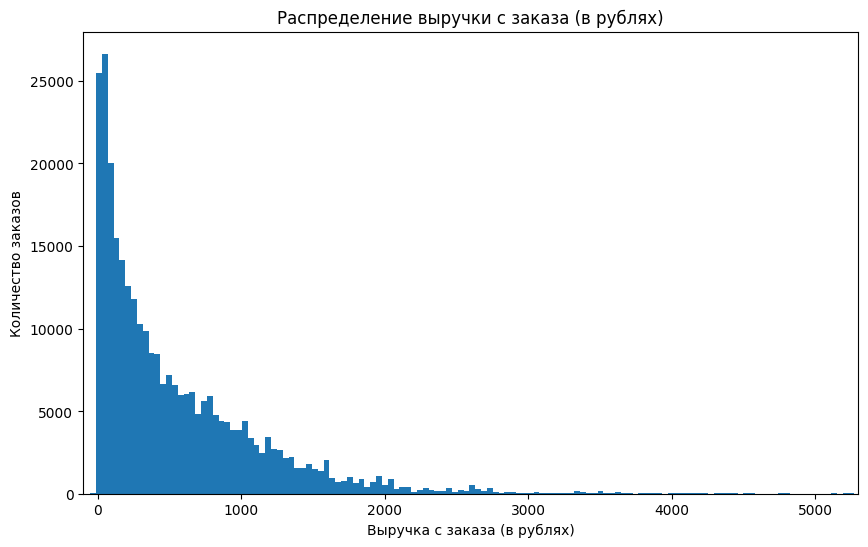

In [15]:
plt.figure(figsize=(10,6))
df['revenue_rub'].plot(kind='hist', bins=2000, xlim=(-100, 5300))
plt.title('Распределение выручки с заказа (в рублях)')
plt.xlabel('Выручка с заказа (в рублях)')   
plt.ylabel('Количество заказов')
plt.show()

Максимальное значение выручки 81174.54, что значительно выше 99-го перцентиля (2628.42). Отфильтруем, также удалим ошибочные отрицательные значения, посмотрим заново на гистограмму и построим диаграмму размаха.

In [16]:
percentile_99_rev = df['revenue_rub'].quantile(0.99)
def procentile_filter(row):
    if (row['revenue_rub'] > percentile_99_rev) or (row['revenue_rub'] < 0):
        return np.nan
    else:
        return row['revenue_rub']
    
df['revenue_rub'] = df.apply(procentile_filter, axis=1)
df['revenue_rub'].describe()

count    287405.000000
mean        518.719259
std         511.951843
min           0.000000
25%         112.600000
50%         344.830000
75%         788.900000
max        2628.420000
Name: revenue_rub, dtype: float64

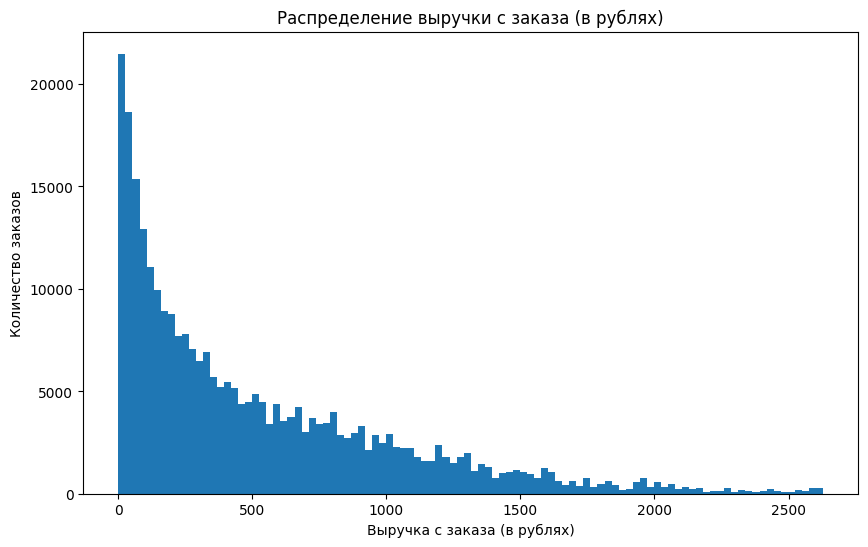

In [17]:
plt.figure(figsize=(10,6))
df['revenue_rub'].plot(kind='hist', bins=100)
plt.title('Распределение выручки с заказа (в рублях)')
plt.xlabel('Выручка с заказа (в рублях)')   
plt.ylabel('Количество заказов')
plt.show()

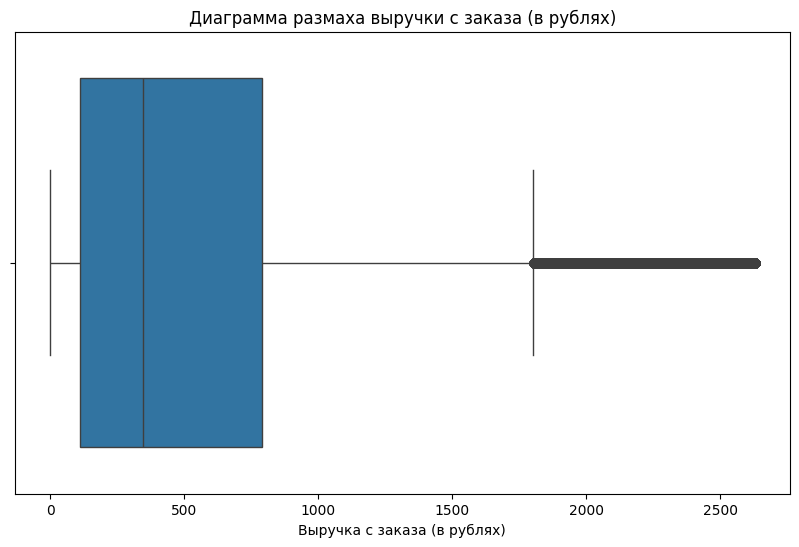

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['revenue_rub'])
plt.title('Диаграмма размаха выручки с заказа (в рублях)')
plt.xlabel('Выручка с заказа (в рублях)')   
plt.show()

После удаления выбросов видим правое ассиметричное распределение выручки с заказов(среднее 518, медиана 345), медиана значительно ниже среднего значения. Диаграмма размаха показывает выбросы, но на гистограмме видно плавное падение количества заказов с увеличением выручки.

In [19]:
df['tickets_count'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
95%           5.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64

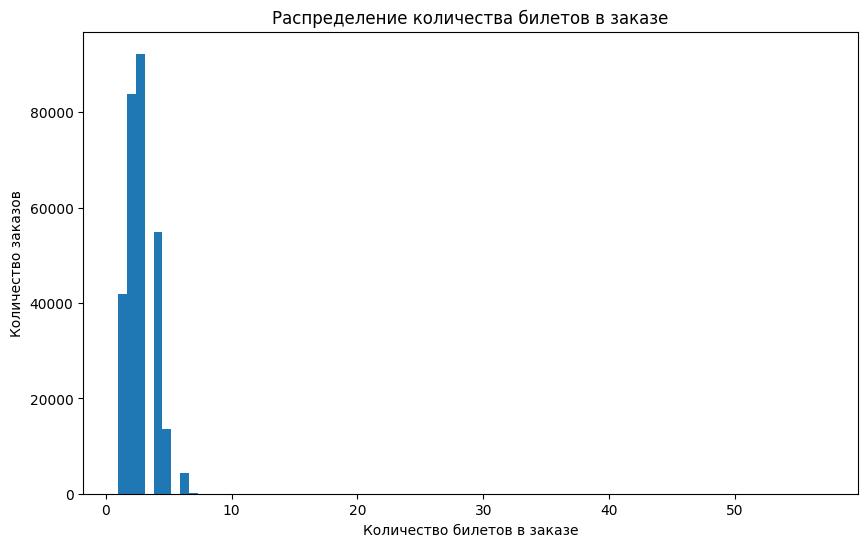

In [20]:
plt.figure(figsize=(10,6))
df['tickets_count'].plot(kind='hist', bins=80)
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов в заказе')   
plt.ylabel('Количество заказов')
plt.show()

Снова похожая картина: максимум 57 билетов на заказ, что значительно выше 99-го перцентиля (6). Отфильтруем заказы с количеством билетов больше 6 и посмотрим на гистограмму и диаграмму размаха.

In [21]:
percentile_99_rev = df['tickets_count'].quantile(0.99)
def procentile_filter(row):
    if row['tickets_count'] > percentile_99_rev:
        return np.nan
    else:
        return row['tickets_count']
    
df['tickets_count'] = df.apply(procentile_filter, axis=1)
df['tickets_count'].describe()

count    290423.000000
mean          2.749366
std           1.143899
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: tickets_count, dtype: float64

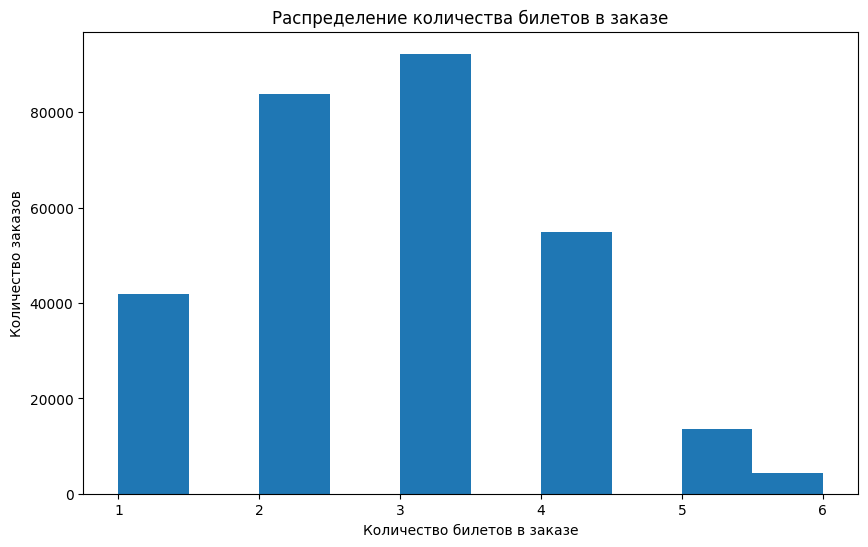

In [22]:
plt.figure(figsize=(10,6))
df['tickets_count'].plot(kind='hist')
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Количество заказов')
plt.show()

После удаления выбросов в количестве билетов в заказе видим незначительно правое ассимметричное распределение (среднее 2.75, медиана 3.0).

In [23]:
df['days_since_prev'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

count    268678.000000
mean          3.222381
std          11.350510
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
95%          18.000000
99%          63.000000
max         148.000000
Name: days_since_prev, dtype: float64

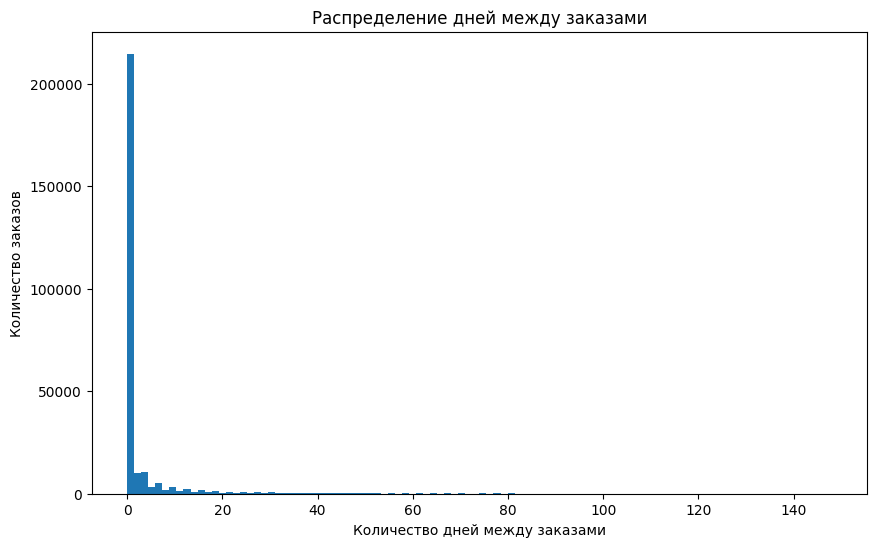

In [24]:
plt.figure(figsize=(10,6))
df['days_since_prev'].plot(kind='hist', bins=100)
plt.title('Распределение дней между заказами')
plt.xlabel('Количество дней между заказами')
plt.ylabel('Количество заказов')
plt.show()

In [25]:
df_test = df.groupby('user_id').agg({
    'order_id': 'nunique','event_id': 'nunique','days_since_prev': 'mean'}).sort_values(by='user_id')
df_test_filtered = df_test.loc[df_test['order_id'] > df_test['event_id']]
display(df_test_filtered)
display(df_test.shape)
display(df_test_filtered.shape)

,order_id,event_id,days_since_prev
user_id,,,
000cf0659a9f40f,13,1,0.083333
00147c9209d45d3,2,1,0.000000
0020c5654c92ec1,2,1,0.000000
002b75ca606ba46,6,5,20.000000
002ec276eee9b0b,22,13,5.380952
...,...,...,...
ffe73c50cbd71fc,2,1,0.000000
ffecf05f1f6a9c6,4,3,20.000000
ffed3ff067d4f12,4,3,26.000000


(21933, 3)

(10136, 3)

В распределении дней между заказами много значений 0, при этом таблица выше показывает, что половина пользователей покупала билеты на одно и то же мероприятие отдельными заказами. Данный факт необходимо учитывать при дальнейшем анализе.

In [26]:
pd.DataFrame({'amount':df.isna().sum(),'share':df.isna().mean()})

,amount,share
user_id,0,0.000000
device_type_canonical,0,0.000000
order_id,0,0.000000
order_dt,0,0.000000
order_ts,0,0.000000
currency_code,0,0.000000
revenue,0,0.000000
tickets_count,188,0.000647
days_since_prev,21933,0.075472
event_id,0,0.000000


In [27]:
pd.DataFrame({'amount':df_copy.isna().sum(),'share':df_copy.isna().mean()})

,amount,share
user_id,0,0.000000
device_type_canonical,0,0.000000
order_id,0,0.000000
order_dt,0,0.000000
order_ts,0,0.000000
currency_code,0,0.000000
revenue,0,0.000000
tickets_count,0,0.000000
days_since_prev,21933,0.075472
event_id,0,0.000000


### Промежуточный вывод
- Пропуски есть только в столбце `days_since_prev`.
- Оптимизировали размерность столбцов:`order_id` - int64 -> int32, `tickets_count` - int64 -> int16, `event_id` - int64 -> int32, `revenue` - float64 -> float32, `revenue_rub` - float64 -> float32, `days_since_prev` - float64 -> float32. В датах нормализировали столбец `order_dt`
- Изучили значения в ключевых столбцах.
    - Среди категорий в столбцах с номинальными данными не таких, что обозначают пропуски в данных или отсутствие информации
    - Отфильтровали значения в `revenue_rub` и `tickets_count` по 99 перцентилю.
    - Отметили, что в `days_since_prev` много нулевых значений, которые связаны с дроблением покупки на одно мероприятие на несколько заказов.

Всего было удалено 188 значений в `tickets_count` (0.07% от общего числа) и 3206 значений в `revenue_rub` (1.1%).


---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Построим для них агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

Построим профиль пользователя — для каждого пользователя найдем:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавим два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.


---


In [29]:
df_profile = df.sort_values(by=['user_id','order_ts']).groupby('user_id').agg(first_order_dt=('order_dt','first'), last_order_dt=('order_dt','last'), device=('device_type_canonical','first'),region=('region_name','first'), 
                                                                              service=('service_name','first'), genre=('event_type_main','first'),total_orders=('order_id','nunique'), avg_revenue_per_order=('revenue_rub','mean'), 
                                                                              avg_tickets=('tickets_count','mean'), avg_days_between_orders=('days_since_prev','mean'))
df_profile.reset_index(inplace=True)
df_profile['is_two'] = df_profile['total_orders'].apply(lambda x: 1 if x>=2 else 0)
df_profile['is_five'] = df_profile['total_orders'].apply(lambda x: 1 if x>=5 else 0)
display(df_profile.head())

,user_id,first_order_dt,last_order_dt,device,region,service,genre,total_orders,avg_revenue_per_order,avg_tickets,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


Построили профиль пользователей с основными характеристиками и признаками лояльности в датафрейме df_profile.


- `first_order_dt` дата первого заказа;
- `last_order_dt` дата последнего заказа;
- `device` устройство, с которого был сделан первый заказ;
- `region` регион, в котором был сделан первый заказ;
- `service` билетного партнёра, к которому обращались при первом заказе;
- `genre` жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- `total_orders` общее количество заказов;
- `avg_revenue_per_order` средняя выручка с одного заказа в рублях;
- `avg_tickets` среднее количество билетов в заказе;
- `avg_days_between_orders` среднее время между заказами.
- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [39]:
#число уникальных пользователей
display(df_profile.shape[0])
#средняя выручка на заказ
display(float(df_profile['avg_revenue_per_order'].mean()))
# доля пользователей, совершивших 2 и более заказа
display(f"{df_profile['is_two'].mean() * 100:.2f}%")
# доля пользователей, совершивших 5 и более заказов
display(f"{df_profile['is_five'].mean() * 100:.2f}%")

21933

545.0328015670657

'61.82%'

'29.18%'

In [43]:
df_profile[['total_orders','avg_tickets','avg_days_between_orders']].describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

,total_orders,avg_tickets,avg_days_between_orders
count,21933.000000,21924.000000,13559.000000
mean,13.249943,2.751419,15.808537
std,122.470535,0.907977,22.249582
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.757464,8.000000
75%,5.000000,3.125000,20.400000
95%,32.000000,4.000000,61.000000
99%,152.000000,5.000000,112.000000
max,10251.000000,6.000000,148.000000


---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**